In [4]:
# !git clone https://github.com/tordjx/ummt.git
# import os 
# os.chdir("ummt/Core model files")
# os.getcwd()
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install nltk --quiet
!pip install torchtext --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = False
load_model = False


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 128

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,'').to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,'').to(device)
model_fr.feedforward= model_en.feedforward
for i in range(3):
  model_fr.decoder.layers[i]= model_en.decoder.layers[i]
  model_fr.encoder.layers[i]= model_en.encoder.layers[i]
prefix = "fulltry"
if load_model : 
    model_en.load_state_dict(torch.load("tordjx/"+prefix+"_en"))
    model_fr.load_state_dict(torch.load("tordjx/"+prefix+"_fr"))
else : 
    with open("logs.txt",'w') as logs :
        logs.write("")
        logs.close()
if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]
def save_model(model_en,model_fr,prefix):
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    import os
    import s3fs
    !pip install pandas
    import pandas
    # Create filesystem object
    S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
    fs.upload("tordjx/"+prefix+"_fr","tordjx/"+prefix+"_fr")
    fs.upload("tordjx/"+prefix+"_en","tordjx/"+prefix+"_en")

In [7]:
#On va entrainer 4 modeles : avec/sans images, avec/sans teacher forcing
teacher_forcing = False
bools = [True,False]
for image_bool in bools : 
    prefix = str(image_bool)+str(teacher_forcing)
    model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    model_fr.feedforward= model_en.feedforward
    for i in range(3):
        model_fr.decoder.layers[i]= model_en.decoder.layers[i]
        model_fr.encoder.layers[i]= model_en.encoder.layers[i]
    with open(prefix+"logs.txt",'w') as logs :
        logs.write("")
        logs.close()
    if image_bool :
        mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,60,batch_size, True,1/2)
    else :
        mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,60,batch_size, False,1/2)
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    pd.DataFrame(model_en.loss_list).to_csv("tordjx/"+prefix+"loss_en.csv")
    pd.DataFrame(model_fr.loss_list).to_csv("tordjx/"+prefix+"loss_fr.csv")
    

d:\Programmes\Python\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
d:\Programmes\Python\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


NameError: name 'batch_size' is not defined

In [5]:
model_en(tokenized_val_en[:batch_size],False)

d:\Programmes\Python\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
d:\Programmes\Python\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


tensor([[[-1.7672,  0.6324, -2.2318,  ...,  3.2074, -1.5971,  0.5021],
         [-1.8711, -1.1175, -1.7387,  ...,  1.9533, -0.6104,  0.6691],
         [-2.5070,  0.7686, -1.9276,  ...,  2.5660, -0.9294,  0.5455],
         ...,
         [-2.2627,  0.6238, -1.7786,  ...,  2.0241, -1.1009,  1.6198],
         [-1.3301,  0.1612, -1.9499,  ...,  1.6829, -1.0265,  1.4370],
         [-1.4545,  0.3633, -1.3041,  ...,  1.8026, -1.3168,  1.2916]],

        [[ 0.4346, -1.8247, -2.3207,  ...,  2.7586, -0.3141, -0.0385],
         [-0.2487, -0.9901, -1.9830,  ...,  2.4211, -0.4552,  0.7975],
         [-0.5314, -0.5862, -1.6345,  ...,  2.3901, -0.4316,  0.7297],
         ...,
         [-1.5806, -0.3029, -1.5977,  ...,  3.0642, -1.3033,  0.8397],
         [-1.0783, -0.6023, -2.4334,  ...,  1.8654, -0.2117,  0.9085],
         [-1.1355, -0.4256, -1.5829,  ...,  3.0951, -1.1788,  1.3038]],

        [[-0.4734, -1.1233, -2.7201,  ...,  3.4664,  0.1761,  0.8877],
         [-1.1830, -1.4720, -1.6237,  ...,  2

In [ ]:
# if image_bool :
#     loss_list = learning_rate_finder(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,1/2)
# else :
#     loss_list = learning_rate_finder(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,150,batch_size, False,1/2)

lrs = [10**(-10)*3**n for n in range(len(loss_list))]
cut = 11
begin = 10
plt.plot(lrs[begin:-cut],loss_list[begin:-cut])
plt.xscale('log')
plt.show()

In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
tokenized_val_en = val_data_en[0]
i = np.random.randint(len(tokenized_val_en)//batch_size)
j = np.random.randint(batch_size)
src,features,tgt = donne_random(i,j,val_data_en,val_data_fr,batch_size,True)
features = features.to(device,dtype=torch.float32)
data = [src,features]
# OUT= traduit('greedy',model_en,model_fr,data, inv_map_en,True,tgt[j],inv_map_fr,j)
OUT = greedy_beam_search.CCF_greedy(model_en,model_fr,src, features, True)
values,indices = torch.topk(OUT,2,2)
print(values)
print(indices)

In [16]:
from torchvision import models, transforms
from PIL import Image
import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
def image_noiser(image):
    image = image + torch.randn(image.shape).to(device)*0.1
    return image
def save_image(image,path):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(path)
    return image
def get_all_images_from_folder(path):
    images = []
    for filename in os.listdir(path):
        images.append(filename)
    return images
#Noisy
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(image_noiser(open_image("Images ummt/raw/"+images)),"Images ummt/noisy/"+images)
#Wrong
folder = get_all_images_from_folder("Images ummt/raw/")
for i in range(len(folder)):
    save_image(open_image("Images ummt/raw/"+folder[i]),"Images ummt/wrong/"+folder[(i+1)%len(folder)])
#Blur
!pip install opencv-python
import cv2
def blur_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.blur(image,(5,5))
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(blur_image(open_image("Images ummt/raw/"+images)),"Images ummt/blurred/"+images)
#Negative
def negative_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = 255-image
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):   
    save_image(negative_image(open_image("Images ummt/raw/"+images)),"Images ummt/negative/"+images)
#Rotation
def rotate_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(rotate_image(open_image("Images ummt/raw/"+images)),"Images ummt/rotated/"+images)
#Contrast
def contrast_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    # image = cv2.equalizeHist(image)
    image= cv2.convertScaleAbs(image, 10, 2)

    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(contrast_image(open_image("Images ummt/raw/"+images)),"Images ummt/contrast/"+images)


In [96]:
with open('Images ummt/captions.txt','r') as file : 
    lines = file.readlines()
    file.close()
def get_resnet_features_from_image(image):
    resnet = models.resnet152(pretrained=True)
    resnet.eval()
    resnet = resnet.to(device)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    image = image.to(device)
    image = image.unsqueeze(0)
    image = resnet(image)
    image = image.squeeze(0)
    return image

lines = [line[:-1].split(',') for line in  lines]
images= [line[0] for line in lines]
captions = [line[1][1:] for line in lines]
folder =[x for x in os.listdir('Images ummt') if x != 'captions.txt']
text=[]
features=[]
for name in folder :
    text+=captions
    # for image in images: 
    #     features.append(get_resnet_features_from_image(open_image('Images ummt/'+name+'/'+image)))
text = [["DEBUT_DE_PHRASE"]+ligne.strip().split(" ")+["FIN_DE_PHRASE"] for ligne in text ]
longueur_max = 64
text = [[phrase[i] if i < len(phrase) else "TOKEN_VIDE" for i in range (longueur_max)] for phrase in text]
text = torch.tensor([[vocab_en[mot] for mot in phrase] for phrase in text]).to(device = device, dtype = torch.long)
text = torch.cat((text, torch.zeros(batch_size-text.shape[0]).to(device = device, dtype = torch.long)))
features = torch.cat(features,torch.zeros(batch_size-features.shape[0],features.shape[1],features.shape[2],features.shape[2]).to(device = device, dtype = torch.float))
#Pour la suite : faire un machin qui fait un dataframe avec la traduction, la source, l'image, le nom de la transformation, le bleu score, l'image source, et l'attention image et text
#Essayer de modifier l'output du decoder pour faire en sorte qu'il output aussi l'attention
#se baser sur le programme traduction dans evaluateur et ça devrait aller

KeyError: 'gate.'

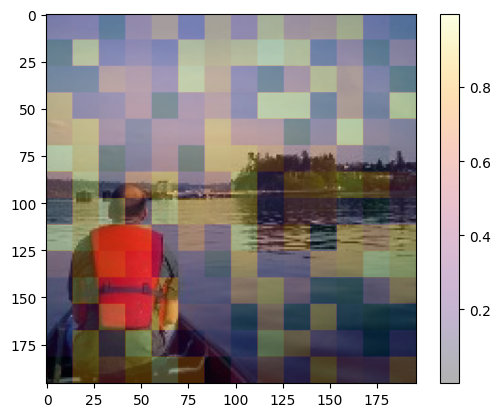

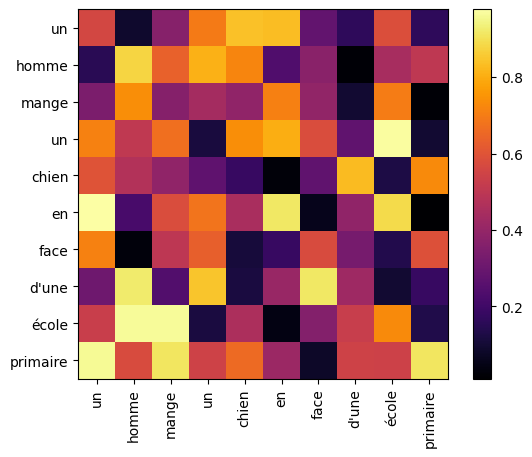

In [85]:
attention = torch.rand(14,14)
def repeater(tensor):
    tensor = tensor.cpu()
    tensor = tensor.detach().numpy()
    tensor = np.repeat(tensor,14,axis=0)
    tensor = np.repeat(tensor,14,axis=1)
    tensor = torch.tensor(tensor)
    return tensor
attention = repeater(attention)
image = open_image('Images ummt/raw/10350842.jpg')
import matplotlib.pyplot as plt

def plot_attention_on_image(image,attention):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    plt.imshow(image)
    plt.imshow(attention,alpha = 0.3,cmap = "inferno")
    plt.colorbar()
    plt.show()
plot_attention_on_image(image,attention)

phrase = "un homme mange un chien en face d'une école primaire".split(" ")
attention_text = torch.rand(len(phrase),len(phrase))
fig, ax = plt.subplots(1,1)
plt.imshow(attention_text,cmap = "inferno")
ax.set_xticks([i for i in range(len(phrase))])
ax.set_xticklabels(phrase,rotation = 90)
ax.set_yticks([i for i in range(len(phrase))])
ax.set_yticklabels(phrase)
plt.colorbar()